In [149]:
import torch
from torchvision.datasets import OxfordIIITPet
from torchvision import transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import wandb
import numpy as np

In [150]:
device = ('cuda' if torch.cuda.is_available() else 'cpu')
device

'cuda'

## Data

In [151]:
train_transform = transforms.Compose([
    transforms.RandomResizedCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],   # Normalization of ImageSet (necessary if we use a model pre-trained on ImageSet, such as ResNet-18)
                         std=[0.229, 0.224, 0.225])
])
test_transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                         std=[0.229, 0.224, 0.225])
])

train_data = OxfordIIITPet(
    root="../data",
    split="trainval",
    transform=train_transform,
    download=True
)
test_data = OxfordIIITPet(
    root="../data",
    split="test",
    transform=test_transform,
    download=True
)
print(f"Training samples: {len(train_data)}")
print(f"Test samples: {len(test_data)}")
print(f'Size of the images: {train_data[0][0].shape}')

Training samples: 3680
Test samples: 3669
Size of the images: torch.Size([3, 224, 224])


In [152]:
class_names = train_data.classes
label_to_breed = {i:name for i, name in enumerate(class_names)}  # Map between the labels and the names of the pet breeds

CAT_BREEDS = {
    "Abyssinian", "Bengal", "Birman", "Bombay", "British_Shorthair", 
    "Egyptian_Mau", "Maine_Coon", "Persian", "Ragdoll", "Russian_Blue", 
    "Siamese", "Sphynx"
}

label_to_species = {i: ('cat' if name in CAT_BREEDS else 'dog')   # Map between the labels and the species of the animal (cat or dog)
                    for i, name in enumerate(class_names)}

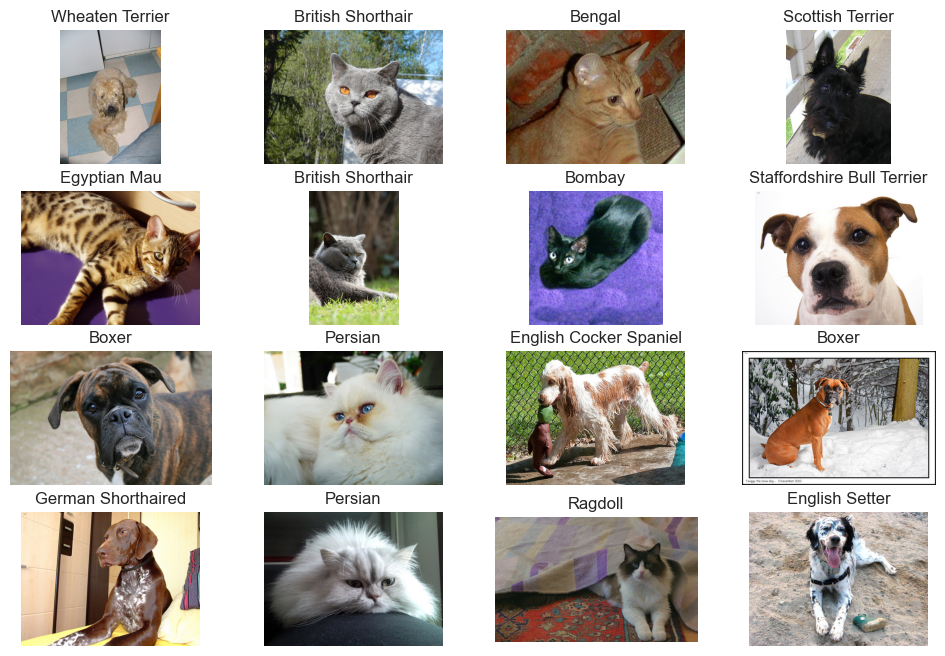

In [153]:
data = train_data
size = 4

# We load the training data without visual transformations so we can visualize the images
visual_data = OxfordIIITPet(root="../data", transform=transforms.ToTensor())

figure = plt.figure(figsize=(3*size, 2*size))
for i in range(1, size**2 + 1):
    sample_idx = torch.randint(len(visual_data), size=(1,)).item()
    image, label = visual_data[sample_idx]
    plt.subplot(size, size, i)
    plt.title(label_to_breed[label])
    plt.axis("off")
    plt.imshow(image.permute(1, 2, 0))
plt.show()

In [154]:
train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=64, shuffle=True)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].


Feature batch shape: torch.Size([64, 3, 224, 224])
Labels batch shape: torch.Size([64])


(np.float64(-0.5), np.float64(223.5), np.float64(223.5), np.float64(-0.5))

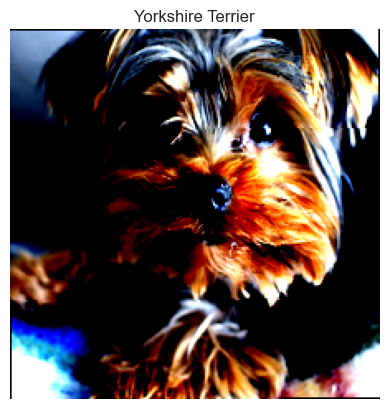

In [155]:
# Display some pre-processed image and label
train_features, train_labels = next(iter(train_dataloader))  # Get next batch of the iterable
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
image = train_features[0]
label = train_labels[0]
plt.imshow(image.permute(1, 2, 0))
plt.title(label_to_breed[label.item()])
plt.axis("off")

## Model

We will explore several models, starting with ResNets

In [156]:
from torchvision import models
from torch import nn
from torch import optim

### Loading

In [157]:
def load_model(model, dropout_p=0.5):
    """
    Load a pre-trained model and set it up for training:
    replace the last fully-connected layer and freeze
    the rest of the model.
    """
    # Freeze all the layers in the base model
    for param in model.parameters():
        param.requires_grad = False

    # Get the number of input features for the classifier
    num_ftrs = model.fc.in_features
    num_classes = len(class_names)

    # Create a new fully-connected layer for our new classes
    model.fc = nn.Sequential(
        nn.Dropout(p=dropout_p),
        nn.Linear(num_ftrs, num_classes)
    ) 

    # Move model to device
    model.to(device)
    
    return model

In [158]:
# Set up ResNet-18
model_resnet18 =  models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
model_resnet18 = load_model(model_resnet18)
# Set up ResNet-34
model_resnet34 =  models.resnet34(weights=models.ResNet34_Weights.DEFAULT)
model_resnet34 = load_model(model_resnet34)

### Training
We are going to implement the fine-tuning of these models in two parts:
1. We train just the last layer with a not very small learning rate (between 0.01 and 0.001) for a few epochs in order to get the new randomly initialized classifier's head to a stable and reasonable state without disturbing the pre-trained weights.

2. We unfreeze all the layers of our model and train it with a very small learning rate (between 0.0001 and 0.00001) for a few more epochs to allow the powerful, pre-trained feature extraction layers to make small, subtle adjustments to better suit the specific details of your dataset

In [ ]:
import torch
from tqdm.auto import tqdm

In [ ]:
def fine_tune(model, dataloaders, loss_fn, optimizer, epochs=10, device='cuda'):
    """
    """ 
    # Create a dictionary to store training history
    history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    train_dataloader, test_dataloader = dataloaders

    # Loop through epochs
    for epoch in range(epochs):
        ### Training Phase ###
        model.train()
        
        train_loss = 0.0
        for X, y in tqdm(train_dataloader, desc=f'Epoch {epoch+1} Training', leave=False):
            # Move data to target device
            X, y = X.to(device), y.to(device)

            # Forward pass
            y_pred = model(X)

            # Calculate loss
            loss = loss_fn(y_pred, y)
            train_loss += loss.item()

            # Optimizer zero grad
            optimizer.zero_grad()

            # Loss backward
            loss.backward()

            # Optimizer step
            optimizer.step()

        # Calculate average training loss for the epoch
        train_loss /= len(train_dataloader)

        ### Validation Phase ###
        model.eval() # Set model to evaluation mode
        
        val_loss, val_acc = 0.0, 0.0
        with torch.inference_mode():
            for X, y in test_dataloader:
                X, y = X.to(device), y.to(device)
                
                # Forward pass
                val_pred = model(X)
                
                # Calculate loss and accuracy
                val_loss += loss_fn(val_pred, y).item()
                val_acc += (val_pred.argmax(dim=1) == y).sum().item()

        # Calculate metrics over the whole validation set
        val_loss /= len(test_dataloader)
        val_acc /= len(test_dataloader.dataset)

        # Print progress
        print(f"Epoch: {epoch+1} | "
              f"Train loss: {train_loss:.4f} | "
              f"Val loss: {val_loss:.4f} | "
              f"Val acc: {val_acc:.4f}")

        # Store history
        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['val_acc'].append(val_acc)
        
        wandb.log({
            "train_loss": train_loss,
            "val_loss": val_loss,
            "val_acc": val_acc
        })
        
    return history
    
def fine_tune_full(model, dataloaders, loss_fn, optimizers, epochs_head=5, epochs_full=5, device='cuda'):
    """
    """
    optimizer_head, optimizer_full = optimizers
    
    # Train the head of the model
    print('Training model\'s head...')
    history_head = fine_tune(model, dataloaders, loss_fn, optimizer_head, epochs=epochs_head, device=device)
    
    # Unfreeze all layers
    for param in model.parameters():
        param.requires_grad = True
        
    print('Training full model...')
    # Train the full model
    history_full = fine_tune(model, dataloaders, loss_fn, optimizer_full, epochs=epochs_full, device=device)
    print('Finished Training')
    
    # Join the histories
    history = {'train_loss': history_head['train_loss'] + history_full['train_loss'], 
               'val_loss': history_head['val_loss'] + history_full['val_loss'], 
               'val_acc': history_head['val_acc'] + history_full['val_acc']}
    
    return history

In [161]:
# Loss function
loss_fn = nn.CrossEntropyLoss()

# Optimizers for training only the parameters our classifiers' heads
optim_18_head = optim.Adam(model_resnet18.fc.parameters(), lr=0.002)
optim_34_head = optim.Adam(model_resnet34.fc.parameters(), lr=0.002)

In [162]:
# Optimizers for training the full models
optim_18_full = optim.Adam(model_resnet18.parameters(), lr=0.00001, weight_decay=0.01)
optim_34_full = optim.Adam(model_resnet34.parameters(), lr=0.00001, weight_decay=0.01)

In [163]:
# Initialize experiment tracking for ResNet-18
wandb.init(
    entity = 'nicdeluc-learning',
    project = 'pet-breed-classification',
    config = {
        'lr_head': 0.002,
        'lr_full': 0.00001,
        'architecture': 'ResNet-18',
        'dataset': 'OxfordIIITPet',
        'weight_decay_full': 0.01,
        'epochs_head': 10,
        'epochs_full': 30
    }
)

# Fine-tune ResNet-18
dataloaders_18 = train_dataloader, test_dataloader
optims_18 = optim_18_head, optim_18_full

history_resnet_18 = fine_tune_full(model_resnet18, dataloaders_18, loss_fn, optims_18, epochs_head=10, epochs_full=30)

# End experiment experiment tracking
wandb.finish()

Training model's head...


100%|██████████| 58/58 [00:15<00:00,  3.75it/s]


Epoch: 1 | Train loss: 2.6156 | Val loss: 1.0783 | Val acc: 0.7732


100%|██████████| 58/58 [00:11<00:00,  5.09it/s]


Epoch: 2 | Train loss: 1.5209 | Val loss: 0.7189 | Val acc: 0.8119


100%|██████████| 58/58 [00:11<00:00,  5.08it/s]


Epoch: 3 | Train loss: 1.2440 | Val loss: 0.6126 | Val acc: 0.8327


100%|██████████| 58/58 [00:12<00:00,  4.53it/s]


Epoch: 4 | Train loss: 1.1531 | Val loss: 0.5541 | Val acc: 0.8386


100%|██████████| 58/58 [00:11<00:00,  5.12it/s]


Epoch: 5 | Train loss: 1.1132 | Val loss: 0.4860 | Val acc: 0.8580


100%|██████████| 58/58 [00:17<00:00,  3.25it/s]


Epoch: 6 | Train loss: 1.0556 | Val loss: 0.4807 | Val acc: 0.8506


100%|██████████| 58/58 [00:17<00:00,  3.25it/s]


Epoch: 7 | Train loss: 1.0295 | Val loss: 0.4702 | Val acc: 0.8596


100%|██████████| 58/58 [00:14<00:00,  3.87it/s]


Epoch: 8 | Train loss: 1.0658 | Val loss: 0.4573 | Val acc: 0.8569


100%|██████████| 58/58 [00:15<00:00,  3.75it/s]


Epoch: 9 | Train loss: 1.0086 | Val loss: 0.4574 | Val acc: 0.8585


100%|██████████| 58/58 [00:11<00:00,  5.06it/s]


Epoch: 10 | Train loss: 1.0378 | Val loss: 0.4563 | Val acc: 0.8479
Training full model...


100%|██████████| 58/58 [00:18<00:00,  3.19it/s]


Epoch: 1 | Train loss: 0.8743 | Val loss: 0.4118 | Val acc: 0.8675


100%|██████████| 58/58 [00:11<00:00,  5.20it/s]


Epoch: 2 | Train loss: 0.8332 | Val loss: 0.3808 | Val acc: 0.8763


100%|██████████| 58/58 [00:11<00:00,  5.19it/s]


Epoch: 3 | Train loss: 0.7784 | Val loss: 0.3654 | Val acc: 0.8839


100%|██████████| 58/58 [00:11<00:00,  5.17it/s]


Epoch: 4 | Train loss: 0.7821 | Val loss: 0.3543 | Val acc: 0.8863


100%|██████████| 58/58 [00:11<00:00,  5.14it/s]


Epoch: 5 | Train loss: 0.7168 | Val loss: 0.3547 | Val acc: 0.8855


100%|██████████| 58/58 [00:18<00:00,  3.18it/s]


Epoch: 6 | Train loss: 0.6839 | Val loss: 0.3476 | Val acc: 0.8869


100%|██████████| 58/58 [00:14<00:00,  3.91it/s]


Epoch: 7 | Train loss: 0.6947 | Val loss: 0.3444 | Val acc: 0.8907


100%|██████████| 58/58 [00:11<00:00,  4.96it/s]


Epoch: 8 | Train loss: 0.6828 | Val loss: 0.3376 | Val acc: 0.8904


100%|██████████| 58/58 [00:11<00:00,  4.89it/s]


Epoch: 9 | Train loss: 0.6616 | Val loss: 0.3440 | Val acc: 0.8932


100%|██████████| 58/58 [00:18<00:00,  3.21it/s]


Epoch: 10 | Train loss: 0.6573 | Val loss: 0.3312 | Val acc: 0.8967


100%|██████████| 58/58 [00:17<00:00,  3.23it/s]


Epoch: 11 | Train loss: 0.6388 | Val loss: 0.3250 | Val acc: 0.8964


100%|██████████| 58/58 [00:18<00:00,  3.21it/s]


Epoch: 12 | Train loss: 0.6649 | Val loss: 0.3246 | Val acc: 0.8967


100%|██████████| 58/58 [00:17<00:00,  3.23it/s]


Epoch: 13 | Train loss: 0.6068 | Val loss: 0.3237 | Val acc: 0.8994


100%|██████████| 58/58 [00:17<00:00,  3.24it/s]


Epoch: 14 | Train loss: 0.6125 | Val loss: 0.3185 | Val acc: 0.8989


100%|██████████| 58/58 [00:15<00:00,  3.84it/s]


Epoch: 15 | Train loss: 0.6214 | Val loss: 0.3202 | Val acc: 0.9000


100%|██████████| 58/58 [00:11<00:00,  5.10it/s]


Epoch: 16 | Train loss: 0.5431 | Val loss: 0.3261 | Val acc: 0.8967


100%|██████████| 58/58 [00:11<00:00,  5.17it/s]


Epoch: 17 | Train loss: 0.5741 | Val loss: 0.3137 | Val acc: 0.8994


100%|██████████| 58/58 [00:13<00:00,  4.29it/s]


Epoch: 18 | Train loss: 0.5652 | Val loss: 0.3194 | Val acc: 0.8981


100%|██████████| 58/58 [00:17<00:00,  3.28it/s]


Epoch: 19 | Train loss: 0.5452 | Val loss: 0.3093 | Val acc: 0.9011


100%|██████████| 58/58 [00:17<00:00,  3.26it/s]


Epoch: 20 | Train loss: 0.5401 | Val loss: 0.3112 | Val acc: 0.9016


100%|██████████| 58/58 [00:17<00:00,  3.25it/s]


Epoch: 21 | Train loss: 0.5502 | Val loss: 0.3069 | Val acc: 0.8997


100%|██████████| 58/58 [00:18<00:00,  3.21it/s]


Epoch: 22 | Train loss: 0.5283 | Val loss: 0.3055 | Val acc: 0.9054


100%|██████████| 58/58 [00:18<00:00,  3.21it/s]


Epoch: 23 | Train loss: 0.5373 | Val loss: 0.3031 | Val acc: 0.9057


100%|██████████| 58/58 [00:17<00:00,  3.23it/s]


Epoch: 24 | Train loss: 0.5185 | Val loss: 0.3056 | Val acc: 0.9027


100%|██████████| 58/58 [00:17<00:00,  3.24it/s]


Epoch: 25 | Train loss: 0.5306 | Val loss: 0.3007 | Val acc: 0.9027


100%|██████████| 58/58 [00:17<00:00,  3.24it/s]


Epoch: 26 | Train loss: 0.5223 | Val loss: 0.3047 | Val acc: 0.9024


100%|██████████| 58/58 [00:18<00:00,  3.21it/s]


Epoch: 27 | Train loss: 0.5058 | Val loss: 0.3072 | Val acc: 0.9022


100%|██████████| 58/58 [00:17<00:00,  3.23it/s]


Epoch: 28 | Train loss: 0.4980 | Val loss: 0.3049 | Val acc: 0.9022


100%|██████████| 58/58 [00:17<00:00,  3.23it/s]


Epoch: 29 | Train loss: 0.4869 | Val loss: 0.3041 | Val acc: 0.9008


100%|██████████| 58/58 [00:17<00:00,  3.27it/s]


Epoch: 30 | Train loss: 0.4774 | Val loss: 0.2929 | Val acc: 0.9081
Finished Training


train_loss,█▄▄▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▃▄▄▅▅▅▅▅▅▆▆▇▇▇▇▇▇▇▇▇▇███▇█▇████████████
val_loss,█▅▄▃▃▃▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.47741
val_acc,0.90815
val_loss,0.29289


In [164]:
# Initialize experiment tracking for ResNet-34
wandb.init(
    entity = 'nicdeluc-learning',
    project = 'pet-breed-classification',
    config = {
        'lr_head': 0.002,
        'lr_full': 0.00001,
        'architecture': 'ResNet-34',
        'dataset': 'OxfordIIITPet',
        'weight_decay_full': 0.01,
        'epochs_head': 10,
        'epochs_full': 30
    }
)

# Fine-tune ResNet-34
dataloaders_34 = train_dataloader, test_dataloader
optims_34 = optim_34_head, optim_34_full

history_resnet_34 = fine_tune_full(model_resnet34, dataloaders_34, loss_fn, optims_34, epochs_head=10, epochs_full=30)

# End experiment experiment tracking
wandb.finish()

Training model's head...


100%|██████████| 58/58 [00:18<00:00,  3.13it/s]


Epoch: 1 | Train loss: 2.5227 | Val loss: 0.9641 | Val acc: 0.8021


100%|██████████| 58/58 [00:18<00:00,  3.15it/s]


Epoch: 2 | Train loss: 1.3338 | Val loss: 0.5823 | Val acc: 0.8542


100%|██████████| 58/58 [00:18<00:00,  3.14it/s]


Epoch: 3 | Train loss: 1.1330 | Val loss: 0.4848 | Val acc: 0.8605


100%|██████████| 58/58 [00:18<00:00,  3.11it/s]


Epoch: 4 | Train loss: 1.0412 | Val loss: 0.4387 | Val acc: 0.8667


100%|██████████| 58/58 [00:18<00:00,  3.11it/s]


Epoch: 5 | Train loss: 1.0050 | Val loss: 0.4200 | Val acc: 0.8733


100%|██████████| 58/58 [00:18<00:00,  3.13it/s]


Epoch: 6 | Train loss: 1.0080 | Val loss: 0.3898 | Val acc: 0.8809


100%|██████████| 58/58 [00:18<00:00,  3.12it/s]


Epoch: 7 | Train loss: 0.9730 | Val loss: 0.3978 | Val acc: 0.8744


100%|██████████| 58/58 [00:18<00:00,  3.15it/s]


Epoch: 8 | Train loss: 0.9514 | Val loss: 0.3838 | Val acc: 0.8823


100%|██████████| 58/58 [00:18<00:00,  3.16it/s]


Epoch: 9 | Train loss: 0.9640 | Val loss: 0.3882 | Val acc: 0.8664


100%|██████████| 58/58 [00:18<00:00,  3.15it/s]


Epoch: 10 | Train loss: 0.9161 | Val loss: 0.4009 | Val acc: 0.8675
Training full model...


100%|██████████| 58/58 [00:18<00:00,  3.15it/s]


Epoch: 1 | Train loss: 0.8517 | Val loss: 0.3123 | Val acc: 0.9002


100%|██████████| 58/58 [00:18<00:00,  3.11it/s]


Epoch: 2 | Train loss: 0.7754 | Val loss: 0.2944 | Val acc: 0.9057


100%|██████████| 58/58 [00:18<00:00,  3.12it/s]


Epoch: 3 | Train loss: 0.6684 | Val loss: 0.2809 | Val acc: 0.9079


100%|██████████| 58/58 [00:15<00:00,  3.66it/s]


Epoch: 4 | Train loss: 0.6591 | Val loss: 0.2665 | Val acc: 0.9155


100%|██████████| 58/58 [00:11<00:00,  4.88it/s]


Epoch: 5 | Train loss: 0.6067 | Val loss: 0.2669 | Val acc: 0.9139


100%|██████████| 58/58 [00:12<00:00,  4.79it/s]


Epoch: 6 | Train loss: 0.5613 | Val loss: 0.2586 | Val acc: 0.9166


100%|██████████| 58/58 [00:11<00:00,  4.87it/s]


Epoch: 7 | Train loss: 0.5887 | Val loss: 0.2525 | Val acc: 0.9185


100%|██████████| 58/58 [00:12<00:00,  4.71it/s]


Epoch: 8 | Train loss: 0.5591 | Val loss: 0.2574 | Val acc: 0.9177


100%|██████████| 58/58 [00:17<00:00,  3.24it/s]


Epoch: 9 | Train loss: 0.5541 | Val loss: 0.2466 | Val acc: 0.9196


100%|██████████| 58/58 [00:11<00:00,  4.84it/s]


Epoch: 10 | Train loss: 0.5226 | Val loss: 0.2555 | Val acc: 0.9182


100%|██████████| 58/58 [00:11<00:00,  4.88it/s]


Epoch: 11 | Train loss: 0.4702 | Val loss: 0.2449 | Val acc: 0.9196


100%|██████████| 58/58 [00:17<00:00,  3.24it/s]


Epoch: 12 | Train loss: 0.4789 | Val loss: 0.2455 | Val acc: 0.9163


100%|██████████| 58/58 [00:18<00:00,  3.21it/s]


Epoch: 13 | Train loss: 0.4854 | Val loss: 0.2416 | Val acc: 0.9201


100%|██████████| 58/58 [00:17<00:00,  3.23it/s]


Epoch: 14 | Train loss: 0.4512 | Val loss: 0.2461 | Val acc: 0.9218


100%|██████████| 58/58 [00:18<00:00,  3.20it/s]


Epoch: 15 | Train loss: 0.4563 | Val loss: 0.2453 | Val acc: 0.9204


100%|██████████| 58/58 [00:17<00:00,  3.23it/s]


Epoch: 16 | Train loss: 0.4362 | Val loss: 0.2436 | Val acc: 0.9212


100%|██████████| 58/58 [00:17<00:00,  3.23it/s]


Epoch: 17 | Train loss: 0.4498 | Val loss: 0.2503 | Val acc: 0.9207


100%|██████████| 58/58 [00:18<00:00,  3.21it/s]


Epoch: 18 | Train loss: 0.4481 | Val loss: 0.2391 | Val acc: 0.9226


100%|██████████| 58/58 [00:17<00:00,  3.22it/s]


Epoch: 19 | Train loss: 0.4091 | Val loss: 0.2424 | Val acc: 0.9220


100%|██████████| 58/58 [00:17<00:00,  3.23it/s]


Epoch: 20 | Train loss: 0.4187 | Val loss: 0.2492 | Val acc: 0.9193


100%|██████████| 58/58 [00:17<00:00,  3.22it/s]


Epoch: 21 | Train loss: 0.3896 | Val loss: 0.2527 | Val acc: 0.9207


100%|██████████| 58/58 [00:17<00:00,  3.24it/s]


Epoch: 22 | Train loss: 0.3934 | Val loss: 0.2527 | Val acc: 0.9218


100%|██████████| 58/58 [00:17<00:00,  3.24it/s]


Epoch: 23 | Train loss: 0.4160 | Val loss: 0.2431 | Val acc: 0.9234


100%|██████████| 58/58 [00:17<00:00,  3.22it/s]


Epoch: 24 | Train loss: 0.3983 | Val loss: 0.2394 | Val acc: 0.9226


100%|██████████| 58/58 [00:18<00:00,  3.21it/s]


Epoch: 25 | Train loss: 0.3797 | Val loss: 0.2527 | Val acc: 0.9218


100%|██████████| 58/58 [00:12<00:00,  4.79it/s]


Epoch: 26 | Train loss: 0.3503 | Val loss: 0.2455 | Val acc: 0.9193


100%|██████████| 58/58 [00:12<00:00,  4.79it/s]


Epoch: 27 | Train loss: 0.3496 | Val loss: 0.2407 | Val acc: 0.9229


100%|██████████| 58/58 [00:11<00:00,  4.83it/s]


Epoch: 28 | Train loss: 0.3555 | Val loss: 0.2458 | Val acc: 0.9229


100%|██████████| 58/58 [00:17<00:00,  3.24it/s]


Epoch: 29 | Train loss: 0.3677 | Val loss: 0.2491 | Val acc: 0.9229


100%|██████████| 58/58 [00:17<00:00,  3.23it/s]


Epoch: 30 | Train loss: 0.3564 | Val loss: 0.2406 | Val acc: 0.9256
Finished Training


train_loss,█▄▄▃▃▃▃▃▃▃▃▂▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_acc,▁▄▄▅▅▅▅▆▅▅▇▇▇▇▇▇█████▇██████████████████
val_loss,█▄▃▃▃▂▃▂▂▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
train_loss,0.35637
val_acc,0.92559
val_loss,0.24058


In [165]:
# Save the models
RESNET_18_PATH = '../tuned_models/fine_tuned_resnet18.pth'
torch.save(model_resnet18.state_dict(), RESNET_18_PATH)
RESNET_34_PATH = '../tuned_models/fine_tuned_resnet34.pth'
torch.save(model_resnet34.state_dict(), RESNET_34_PATH)

In [166]:
# Funtion to plot training and test losses and accuracy
def plot_history(history):
    # Extract data from the history dictionary
    train_loss = history['train_loss']
    val_loss = history['val_loss']
    val_acc = history['val_acc']
    
    # Create an x-axis for epochs
    epochs = range(1, len(train_loss) + 1)
    
    # Create a figure with two subplots
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))
    
    # Plot 1: training and validation loss
    ax1.plot(epochs, train_loss, 'b-o', label='Training Loss')
    ax1.plot(epochs, val_loss, 'r-o', label='Validation Loss')
    ax1.set_title('Training & Validation Loss')
    ax1.set_xlabel('Epochs')
    ax1.set_ylabel('Loss')
    ax1.legend()
    
    # Plot 2: Validation Accuracy
    ax2.plot(epochs, val_acc, 'g-o', label='Validation Accuracy')
    ax2.set_title('Validation Accuracy')
    ax2.set_xlabel('Epochs')
    ax2.set_ylabel('Accuracy')
    ax2.legend()
    
    # Show the plots
    plt.tight_layout()
    plt.show()

## Metrics

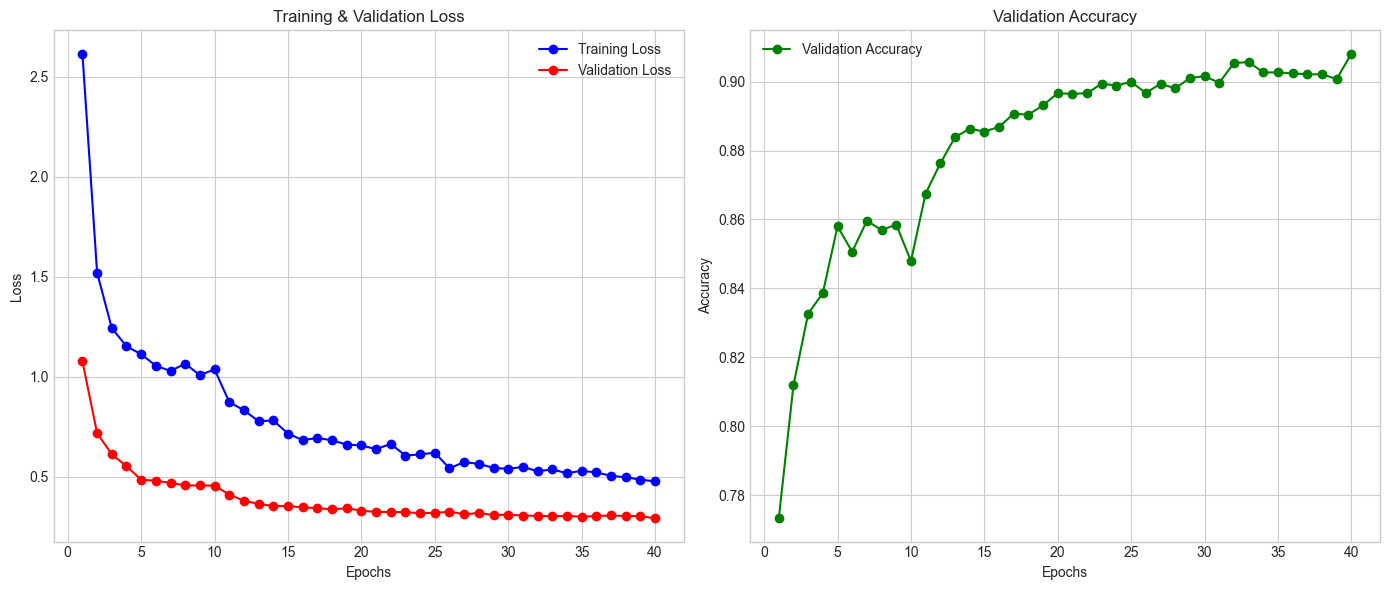

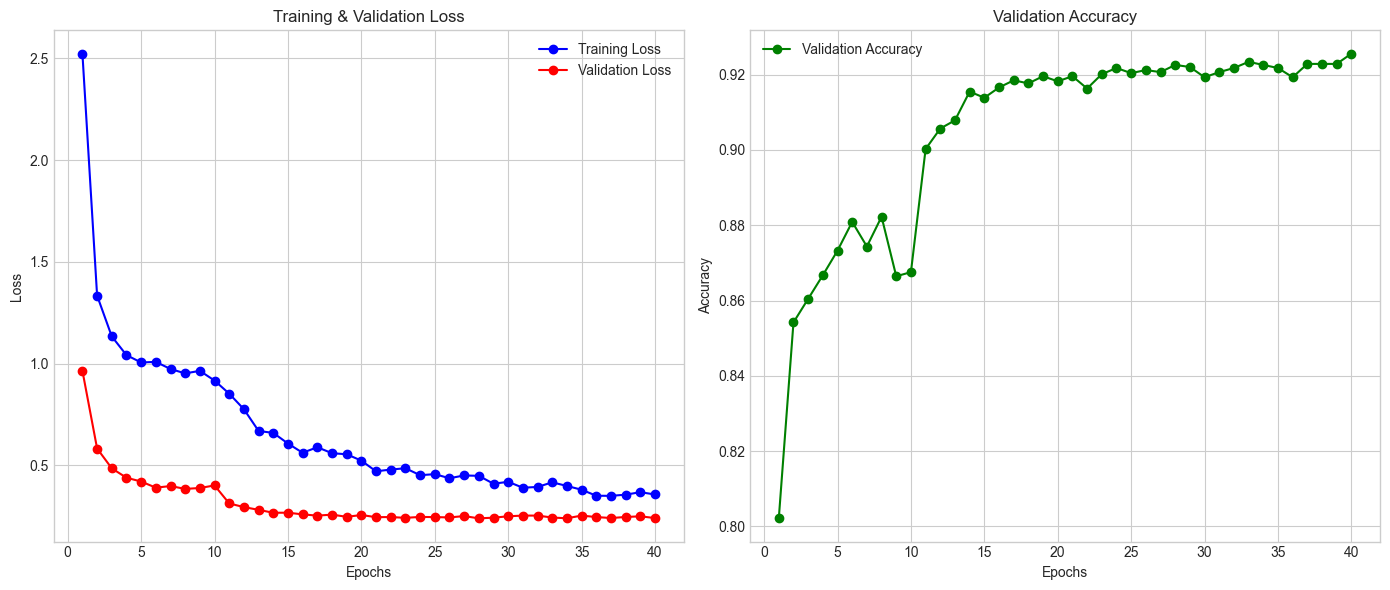

In [167]:
# Plot the histories
plot_history(history_resnet_18)
plot_history(history_resnet_34)

In [168]:
# TODO:
# - Split val set into val and test sets
# - Implement early stopping
# - Make function to evaluate the models (at the very end of the project) on the test set